### Seafloor 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
import os
import time
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# Set seeds for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
sns.set_palette('deep')

In [2]:
# Function to create directories if they don't exist
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

ensure_dir('data/fitur_clean')

# Load the data
print("Loading data...")
df = pd.read_csv('data/fitur_clean/hydrostatic1.csv', parse_dates=['depth_reading_time'])
print(f"Data loaded with shape: {df.shape}")

# Display basic information about the dataset
print("\nBasic information about the dataset:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Check the correlation between seafloor_pressure and hydrostatic_pressure
if not df['seafloor_pressure'].isna().all():
    pressure_correlation = df['seafloor_pressure'].corr(df['hydrostatic_pressure'])
    print(f"\nCorrelation between seafloor_pressure and hydrostatic_pressure: {pressure_correlation:.4f}")

Loading data...
Data loaded with shape: (21888, 60)

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 60 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   measurement_id                                21888 non-null  int64         
 1   depth_reading_time                            21888 non-null  datetime64[ns]
 2   water_temperature_50m                         21888 non-null  float64       
 3   salinity_50m                                  21888 non-null  float64       
 4   oxygen_saturation_50m                         21888 non-null  float64       
 5   perceived_water_density                       21888 non-null  float64       
 6   sediment_deposition                           21888 non-null  float64       
 7   seafloor_pressure                             20599 non-nu

In [4]:
# ----------------------------------------
# Advanced Feature Engineering
# ----------------------------------------
print("\nPerforming advanced feature engineering...")

def create_advanced_features(df):
    """
    Create advanced features for the seafloor pressure imputation model based on
    domain knowledge of oceanography and fluid dynamics.
    """
    # Make a copy of the dataframe to avoid modifying the original
    df_engineered = df.copy()
    
    # 1. Density-related features (using water temperature and salinity)
    # Relationship between temperature, salinity, and density
    if 'water_temperature_50m' in df.columns and 'salinity_50m' in df.columns:
        df_engineered['temp_salinity_interaction'] = df['water_temperature_50m'] * df['salinity_50m']
        
        # Density anomaly approximation (simplified UNESCO equation)
        # This is a simplified version of the equation of state for seawater
        df_engineered['density_anomaly'] = df['salinity_50m'] * 0.8 - (df['water_temperature_50m'] - 273.15) * 0.2
    
    # 2. Depth and pressure relationships
    # Calculate hydrostatic pressure gradient features
    if 'mixed_layer_depth (m)' in df.columns:
        # Theoretical pressure based on depth (1 meter of depth ≈ 0.1 bar of pressure)
        df_engineered['theoretical_pressure'] = df['mixed_layer_depth (m)'] * 0.1
        
        # Create pressure-depth ratio for varying conditions
        if 'hydrostatic_pressure' in df.columns:
            with np.errstate(divide='ignore', invalid='ignore'):
                df_engineered['pressure_depth_ratio'] = df['hydrostatic_pressure'] / df['mixed_layer_depth (m)']
            # Replace infinities and NaNs with median or 0
            median_ratio = df_engineered['pressure_depth_ratio'].median()
            df_engineered['pressure_depth_ratio'].replace([np.inf, -np.inf, np.nan], median_ratio, inplace=True)
    
    # 3. Water column stability features
    if 'Brunt_Vaisala_frequency_squared (s-2)' in df.columns:
        # Square root of BV frequency gives actual frequency
        df_engineered['water_column_stability'] = np.sqrt(np.abs(df['Brunt_Vaisala_frequency_squared (s-2)']))
        
    # 4. Wave and surface features
    if 'significant_wave_height (m)' in df.columns and 'sea_surface_height_anomaly (cm)' in df.columns:
        # Wave energy is proportional to height squared
        df_engineered['wave_energy'] = df['significant_wave_height (m)'] ** 2
        
        # Combined surface disturbance
        df_engineered['surface_disturbance'] = df['significant_wave_height (m)'] + df['sea_surface_height_anomaly (cm)']/100
    
    # 5. Current-related features
    current_cols = ['current_velocity_near_surface', 'current_velocity_deep', 
                   'current_direction_near_surface', 'current_direction_deep']
    if all(col in df.columns for col in current_cols):
        # Convert directions to radians for calculations
        df_engineered['current_dir_surface_rad'] = np.radians(df['current_direction_near_surface'])
        df_engineered['current_dir_deep_rad'] = np.radians(df['current_direction_deep'])
        
        # Calculate x and y components of currents (vector decomposition)
        df_engineered['surface_current_x'] = df['current_velocity_near_surface'] * np.cos(df_engineered['current_dir_surface_rad'])
        df_engineered['surface_current_y'] = df['current_velocity_near_surface'] * np.sin(df_engineered['current_dir_surface_rad'])
        df_engineered['deep_current_x'] = df['current_velocity_deep'] * np.cos(df_engineered['current_dir_deep_rad'])
        df_engineered['deep_current_y'] = df['current_velocity_deep'] * np.sin(df_engineered['current_dir_deep_rad'])
        
        # Current shear (difference between surface and deep currents)
        df_engineered['current_shear_x'] = df_engineered['surface_current_x'] - df_engineered['deep_current_x']
        df_engineered['current_shear_y'] = df_engineered['surface_current_y'] - df_engineered['deep_current_y']
        df_engineered['current_shear_magnitude'] = np.sqrt(df_engineered['current_shear_x']**2 + df_engineered['current_shear_y']**2)
        
        # Clean up intermediate columns
        df_engineered.drop(['current_dir_surface_rad', 'current_dir_deep_rad'], axis=1, inplace=True)
    
    # 6. Sediment pressure indicators
    sediment_porosity_cols = [col for col in df.columns if 'sediment_porosity' in col]
    sediment_temp_cols = [col for col in df.columns if 'sediment_temperature' in col]
    
    if sediment_porosity_cols and sediment_temp_cols:
        # Average porosity and temperature across sediment layers
        df_engineered['avg_sediment_porosity'] = df[sediment_porosity_cols].mean(axis=1)
        df_engineered['avg_sediment_temperature'] = df[sediment_temp_cols].mean(axis=1)
        
        # Porosity gradient (difference between top and deepest layer)
        if 'sediment_porosity_0_to_10cm' in df.columns and 'sediment_porosity_100_to_250cm' in df.columns:
            df_engineered['porosity_gradient'] = df['sediment_porosity_0_to_10cm'] - df['sediment_porosity_100_to_250cm']
        
        # Temperature gradient (difference between top and deepest layer)
        if 'sediment_temperature_0_to_10cm' in df.columns and 'sediment_temperature_100_to_250cm' in df.columns:
            df_engineered['temp_gradient'] = df['sediment_temperature_0_to_10cm'] - df['sediment_temperature_100_to_250cm']
    
    # 7. Chemical and biological properties that affect pressure
    chem_cols = ['nitrate_concentration (µmol L-1)', 'phosphate_concentration (µmol L-1)', 'silicate_concentration (µmol L-1)', 
                'dissolved_inorganic_carbon', 'total_alkalinity']
    if all(col in df.columns for col in chem_cols):
        # Create nutrient composite index
        df_engineered['nutrient_index'] = (df['nitrate_concentration (µmol L-1)'] + df['phosphate_concentration (µmol L-1)'] + 
                                         df['silicate_concentration (µmol L-1)']) / 3
        
        # Carbon chemistry index
        df_engineered['carbon_chemistry_index'] = df['dissolved_inorganic_carbon'] / df['total_alkalinity']
    
    # 8. Calculate water density from temperature, salinity and pressure (UNESCO equation simplified)
    if 'water_temperature_50m' in df.columns and 'salinity_50m' in df.columns:
        # Convert Kelvin to Celsius for calculation
        temp_C = df['water_temperature_50m'] - 273.15
        
        # Calculate density using simplified equation
        # ρ = ρ₀ + A*S + B*t + C*S*t
        # where ρ₀ = 999.842594, A = 0.824493, B = -0.0423, C = -0.00076
        df_engineered['calculated_density'] = 999.842594 + 0.824493 * df['salinity_50m'] - 0.0423 * temp_C - 0.00076 * df['salinity_50m'] * temp_C
    
    # 9. Sound speed features - relationships with density and pressure
    if 'sound_speed_water (m s-1)' in df.columns:
        # Sound speed is related to compressibility which affects pressure
        if 'water_temperature_50m' in df.columns and 'salinity_50m' in df.columns:
            # Sound speed relationship with T and S
            df_engineered['sound_speed_anomaly'] = df['sound_speed_water (m s-1)'] - (1449.2 + 4.6 * (df['water_temperature_50m'] - 273.15) + 0.055 * (df['water_temperature_50m'] - 273.15)**2 + 1.3 * (df['salinity_50m'] - 35))
    
    # 10. Cyclic time features
    if 'hour' in df.columns:
        # Sine and cosine transformations for cyclic patterns
        df_engineered['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df_engineered['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    if 'month' in df.columns:
        df_engineered['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df_engineered['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # # 11. Planetary-scale feature: Tidal force approximation
    # if 'depth_reading_time' in df.columns:
    #     # Convert datetime to timestamp for calculations
    #     if isinstance(df['depth_reading_time'].iloc[0], str):
    #         df_engineered['timestamp'] = pd.to_datetime(df['depth_reading_time']).astype(int) / 10**9
    #     else:
    #         df_engineered['timestamp'] = df['depth_reading_time'].astype(int) / 10**9
            
    #     # Simple tidal cycle approximation (M2 tidal component, 12.42 hours)
    #     df_engineered['tidal_cycle'] = np.sin(2 * np.pi * df_engineered['timestamp'] / (12.42 * 3600))
        
    #     # Drop intermediate timestamp column
    #     df_engineered.drop('timestamp', axis=1, inplace=True)
    
    # 12. Combined features that might approximate pressure
    if 'mixed_layer_depth (m)' in df.columns and 'perceived_water_density' in df.columns:
        # Basic hydrostatic pressure approximation: P = ρ * g * h
        # g = 9.81 m/s²
        df_engineered['hydrostatic_approx'] = df['perceived_water_density'] * 9.81 * df['mixed_layer_depth (m)'] / 100000  # convert to bar
    
    # 13. Polynomial features for key variables highly correlated with seafloor_pressure
    if 'mixed_layer_depth (m)' in df.columns:
        df_engineered['mixed_layer_depth_squared'] = df['mixed_layer_depth (m)'] ** 2
        df_engineered['mixed_layer_depth_cubed'] = df['mixed_layer_depth (m)'] ** 3
    
    if 'nitrate_concentration (µmol L-1)' in df.columns:
        df_engineered['nitrate_squared'] = df['nitrate_concentration (µmol L-1)'] ** 2
    
    # 14. Optical property interactions
    light_cols = ['downwelling_light', 'scattered_light', 'perpendicular_light_intensity']
    if all(col in df.columns for col in light_cols):
        df_engineered['total_light_calculated'] = df['downwelling_light'] + df['scattered_light'] + df['perpendicular_light_intensity']
        
        if 'light_attenuation_coefficient_Kd (m⁻¹)' in df.columns:
            # Beer-Lambert Law relationship for light penetration
            df_engineered['light_penetration_depth'] = 1 / (df['light_attenuation_coefficient_Kd (m⁻¹)'] + 0.0001)  # Adding small constant to avoid division by zero
    
    # 15. Physical oceanography composites
    if 'mixed_layer_depth (m)' in df.columns and 'Brunt_Vaisala_frequency_squared (s-2)' in df.columns:
        # Water column stability index
        df_engineered['water_column_stability_index'] = df['mixed_layer_depth (m)'] * np.sqrt(np.abs(df['Brunt_Vaisala_frequency_squared (s-2)']))
    
    return df_engineered

# Apply advanced feature engineering
df_engineered = create_advanced_features(df)

# Check shape after feature engineering
print(f"Shape after feature engineering: {df_engineered.shape}")

# Check for and handle any new NaNs created during feature engineering
print("\nMissing values after feature engineering:")
missing_after_fe = df_engineered.isnull().sum()
print(missing_after_fe[missing_after_fe > 0])

# Fill NaNs in engineered features with median
cols_with_nans = missing_after_fe[missing_after_fe > 0].index.tolist()
for col in cols_with_nans:
    if col != 'seafloor_pressure' and col != 'hydrostatic_pressure':  # Don't impute target or the column we're trying to predict
        df_engineered[col].fillna(df_engineered[col].median(), inplace=True)


Performing advanced feature engineering...
Shape after feature engineering: (21888, 91)

Missing values after feature engineering:
seafloor_pressure       1289
hydrostatic_pressure    1289
dtype: int64


In [7]:
# ----------------------------------------
# Identify most important features for seafloor_pressure
# ----------------------------------------

# Create a mask for rows where seafloor_pressure is not NaN
seafloor_not_nan_mask = ~df_engineered['seafloor_pressure'].isna()

if seafloor_not_nan_mask.sum() > 0:  # Check if we have any non-NaN seafloor_pressure values
    print("\nIdentifying most important features for seafloor_pressure...")
    
    # Split features and target for rows where seafloor_pressure is not NaN
    X_known = df_engineered.loc[seafloor_not_nan_mask].drop(['depth_reading_time','seafloor_pressure', 'hydrostatic_pressure'], axis=1)
    y_known = df_engineered.loc[seafloor_not_nan_mask, 'seafloor_pressure']
    
    # Handle categorical columns
    cat_cols = X_known.select_dtypes(include=['object', 'category']).columns.tolist()
    X_known_processed = X_known.copy()
    
    # Convert categorical columns to numerical using one-hot encoding
    if cat_cols:
        X_known_processed = pd.get_dummies(X_known_processed, columns=cat_cols, drop_first=True)
    
    # Train a quick Random Forest to evaluate feature importance
    feature_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    feature_selector.fit(X_known_processed, y_known)
    
    # Get feature importances
    importances = feature_selector.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_known_processed.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 features for seafloor_pressure prediction:")
    print(importance_df.head(20))
    
    # Compute correlations with seafloor_pressure for top features
    print("\nCorrelations with seafloor_pressure for top features:")
    correlations = []
    
    for feature in importance_df['feature'].head(20):
        if feature in X_known.columns:  # Only for original features, not one-hot encoded
            corr, _ = pearsonr(X_known[feature], y_known)
            correlations.append((feature, corr))
    
    for feature, corr in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
        print(f"{feature}: {corr:.4f}")


Identifying most important features for seafloor_pressure...

Top 20 features for seafloor_pressure prediction:
                                 feature  importance
23        sediment_porosity_100_to_250cm    0.231346
0                         measurement_id    0.122586
53                                  hour    0.082671
77                              hour_sin    0.048624
20           sediment_porosity_0_to_10cm    0.035784
72              avg_sediment_temperature    0.033668
55                            weekofyear    0.031868
27                     thermal_emissions    0.026087
18      sediment_temperature_30_to_100cm    0.024756
16        sediment_temperature_0_to_10cm    0.024164
52                                   day    0.021960
21          sediment_porosity_10_to_30cm    0.019259
74                         temp_gradient    0.012199
79                             month_sin    0.010702
26         perpendicular_light_intensity    0.010416
60                  pressure_depth_rati

In [8]:
# ----------------------------------------
# Prepare data for seafloor_pressure imputation
# ----------------------------------------

# Create a full preprocessing pipeline
def preprocess_data(df, target_col='seafloor_pressure'):
    """
    Preprocess data for modeling, handling categorical features and scaling.
    """
    print("\nPreprocessing data...")
    
    # Split into rows with known target and rows with missing target
    known_mask = ~df[target_col].isna()
    unknown_mask = df[target_col].isna()
    
    # Separate features and target for known values
    X_known = df.loc[known_mask].drop(['seafloor_pressure', 'hydrostatic_pressure'], axis=1)
    y_known = df.loc[known_mask, target_col]
    
    # Features for unknown values
    X_unknown = df.loc[unknown_mask].drop(['seafloor_pressure', 'hydrostatic_pressure'], axis=1)
    
    # Identify categorical columns
    cat_cols = X_known.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Handle datetime columns
    datetime_cols = X_known.select_dtypes(include=['datetime64']).columns.tolist()
    if datetime_cols:
        for col in datetime_cols:
            # Extract datetime components
            X_known[f"{col}_year"] = pd.to_datetime(X_known[col]).dt.year
            X_known[f"{col}_month"] = pd.to_datetime(X_known[col]).dt.month
            X_known[f"{col}_day"] = pd.to_datetime(X_known[col]).dt.day
            X_known[f"{col}_hour"] = pd.to_datetime(X_known[col]).dt.hour
            
            # Do the same for unknown set
            X_unknown[f"{col}_year"] = pd.to_datetime(X_unknown[col]).dt.year
            X_unknown[f"{col}_month"] = pd.to_datetime(X_unknown[col]).dt.month
            X_unknown[f"{col}_day"] = pd.to_datetime(X_unknown[col]).dt.day
            X_unknown[f"{col}_hour"] = pd.to_datetime(X_unknown[col]).dt.hour
            
        # Drop original datetime columns
        X_known.drop(datetime_cols, axis=1, inplace=True)
        X_unknown.drop(datetime_cols, axis=1, inplace=True)
    
    # One-hot encode categorical columns
    if cat_cols:
        X_known_processed = pd.get_dummies(X_known, columns=cat_cols, drop_first=True)
        # Ensure X_unknown has the same columns
        X_unknown_processed = pd.get_dummies(X_unknown, columns=cat_cols, drop_first=True)
        
        # Ensure both dataframes have the same columns
        missing_cols = set(X_known_processed.columns) - set(X_unknown_processed.columns)
        for col in missing_cols:
            X_unknown_processed[col] = 0
            
        X_unknown_processed = X_unknown_processed[X_known_processed.columns]
    else:
        X_known_processed = X_known
        X_unknown_processed = X_unknown
    
    # Handle any remaining NaNs in the features
    for col in X_known_processed.columns:
        if X_known_processed[col].isna().sum() > 0:
            median_val = X_known_processed[col].median()
            X_known_processed[col].fillna(median_val, inplace=True)
            X_unknown_processed[col].fillna(median_val, inplace=True)
    
    return X_known_processed, y_known, X_unknown_processed, known_mask, unknown_mask

# Get preprocessed data
X_known, y_known, X_unknown, known_mask, unknown_mask = preprocess_data(df_engineered)

print(f"\nTraining data shape: X_known {X_known.shape}, y_known {y_known.shape}")
print(f"Data to impute shape: X_unknown {X_unknown.shape}")

# Verify no missing values in training data
print(f"Missing values in X_known: {X_known.isnull().sum().sum()}")
print(f"Missing values in y_known: {y_known.isnull().sum()}")



Preprocessing data...

Training data shape: X_known (20599, 92), y_known (20599,)
Data to impute shape: X_unknown (1289, 92)
Missing values in X_known: 0
Missing values in y_known: 0


In [9]:
# ----------------------------------------
# Impute seafloor_pressure with CatBoost
# ----------------------------------------

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_known, y_known, test_size=0.2, random_state=42
)

print("\nTraining CatBoost model for seafloor_pressure imputation...")

# Define CatBoost parameters
catboost_params = {
    'iterations': 3000,
    'learning_rate': 0.03,
    'depth': 7,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'early_stopping_rounds': 100,
    'verbose': 100,
    'task_type': 'CPU',  # Change to 'GPU' if available
    'random_seed': 42
}

# Create CatBoost pool objects for better performance
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Train CatBoost model
catboost_model = CatBoostRegressor(**catboost_params)
catboost_model.fit(train_pool, eval_set=val_pool)

# Evaluate model
val_predictions = catboost_model.predict(X_val)
r2 = r2_score(y_val, val_predictions)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

print(f"\nCatBoost validation results:")
print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


Training CatBoost model for seafloor_pressure imputation...
0:	learn: 0.0332797	test: 0.0320747	best: 0.0320747 (0)	total: 147ms	remaining: 7m 21s
100:	learn: 0.7403072	test: 0.7240491	best: 0.7240491 (100)	total: 1.14s	remaining: 32.7s
200:	learn: 0.8150276	test: 0.7970799	best: 0.7970799 (200)	total: 2.01s	remaining: 27.9s
300:	learn: 0.8555789	test: 0.8359398	best: 0.8359398 (300)	total: 2.89s	remaining: 26s
400:	learn: 0.8836444	test: 0.8630252	best: 0.8630252 (400)	total: 3.77s	remaining: 24.5s
500:	learn: 0.9027397	test: 0.8811102	best: 0.8811102 (500)	total: 4.66s	remaining: 23.2s
600:	learn: 0.9154030	test: 0.8926529	best: 0.8926529 (600)	total: 5.55s	remaining: 22.2s
700:	learn: 0.9245631	test: 0.9009254	best: 0.9009254 (700)	total: 6.44s	remaining: 21.1s
800:	learn: 0.9316954	test: 0.9069671	best: 0.9069671 (800)	total: 7.31s	remaining: 20.1s
900:	learn: 0.9376414	test: 0.9119160	best: 0.9119160 (900)	total: 8.2s	remaining: 19.1s
1000:	learn: 0.9426089	test: 0.9160551	best: 

In [10]:
# ----------------------------------------
# Hyper-parameter tuning with Optuna
# ----------------------------------------

print("\nPerforming hyper-parameter tuning with Optuna...")

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10) 
            if trial.params.get('bootstrap_type') == 'Bayesian' else None,
        'subsample': trial.suggest_float('subsample', 0.5, 1.0) 
            if trial.params.get('bootstrap_type') == 'Bernoulli' else None,
        'loss_function': 'RMSE',
        'eval_metric': 'R2',
        'verbose': 0,
        'random_seed': 42
    }
    
    # Remove None values from params
    params = {k: v for k, v in params.items() if v is not None}
    
    # Use cross-validation for more robust evaluation
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X_known):
        X_train_cv, X_val_cv = X_known.iloc[train_idx], X_known.iloc[val_idx]
        y_train_cv, y_val_cv = y_known.iloc[train_idx], y_known.iloc[val_idx]
        
        model = CatBoostRegressor(**params)
        model.fit(
            X_train_cv, y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            early_stopping_rounds=100,
            verbose=0
        )
        
        preds = model.predict(X_val_cv)
        score = r2_score(y_val_cv, preds)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nBest parameters found:")
print(study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

[I 2025-05-14 12:36:42,015] A new study created in memory with name: no-name-22f4ab78-feab-4df5-92e0-0475c9598d6e



Performing hyper-parameter tuning with Optuna...


[I 2025-05-14 12:37:36,470] Trial 0 finished with value: 0.9275641698895392 and parameters: {'iterations': 2815, 'learning_rate': 0.025027764738559555, 'depth': 6, 'l2_leaf_reg': 4.728897562868705, 'bootstrap_type': 'Bernoulli', 'random_strength': 1.8239991548143972e-05, 'subsample': 0.8380565196615296}. Best is trial 0 with value: 0.9275641698895392.
[I 2025-05-14 12:39:54,713] Trial 1 finished with value: 0.9320085822908108 and parameters: {'iterations': 1571, 'learning_rate': 0.020025331269204815, 'depth': 9, 'l2_leaf_reg': 2.45432872257935, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0020041031274915773, 'bagging_temperature': 0.6121501295775933}. Best is trial 1 with value: 0.9320085822908108.
[I 2025-05-14 12:40:24,705] Trial 2 finished with value: 0.908451258573891 and parameters: {'iterations': 2349, 'learning_rate': 0.020088831565911004, 'depth': 5, 'l2_leaf_reg': 3.0034288170589343, 'bootstrap_type': 'Bernoulli', 'random_strength': 1.572289833687871, 'subsample': 0.989


Best parameters found:
{'iterations': 3946, 'learning_rate': 0.05428662424899185, 'depth': 9, 'l2_leaf_reg': 8.645024964832787, 'bootstrap_type': 'MVS', 'random_strength': 0.23741835345006618}
Best R² score: 0.9437


In [11]:
# ----------------------------------------
# Train final model with best parameters
# ----------------------------------------

best_params = study.best_params.copy()
# Remove bootstrap-specific parameters if they don't apply
if best_params['bootstrap_type'] != 'Bayesian' and 'bagging_temperature' in best_params:
    best_params.pop('bagging_temperature')
if best_params['bootstrap_type'] != 'Bernoulli' and 'subsample' in best_params:
    best_params.pop('subsample')

# Add other necessary parameters
best_params.update({
    'loss_function': 'RMSE',
    'eval_metric': 'R2',
    'random_seed': 42,
    'verbose': 100
})

print("\nTraining final model with best parameters...")
final_model = CatBoostRegressor(**best_params)

# Use cross-validation to evaluate the final model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_known, y_known, cv=cv, scoring='r2')

print(f"\nCross-validation R² scores: {cv_scores}")
print(f"Mean R² score: {np.mean(cv_scores):.4f}")

# Train on all known data
final_model.fit(X_known, y_known)


Training final model with best parameters...
0:	learn: 0.0607246	total: 31ms	remaining: 2m 2s
100:	learn: 0.8547259	total: 2.88s	remaining: 1m 49s
200:	learn: 0.9149774	total: 5.71s	remaining: 1m 46s
300:	learn: 0.9376466	total: 8.53s	remaining: 1m 43s
400:	learn: 0.9495970	total: 11.4s	remaining: 1m 40s
500:	learn: 0.9579071	total: 14.2s	remaining: 1m 37s
600:	learn: 0.9640437	total: 17s	remaining: 1m 34s
700:	learn: 0.9690110	total: 19.9s	remaining: 1m 31s
800:	learn: 0.9729867	total: 22.8s	remaining: 1m 29s
900:	learn: 0.9763158	total: 25.7s	remaining: 1m 26s
1000:	learn: 0.9791347	total: 28.6s	remaining: 1m 24s
1100:	learn: 0.9816574	total: 31.5s	remaining: 1m 21s
1200:	learn: 0.9837329	total: 34.3s	remaining: 1m 18s
1300:	learn: 0.9855200	total: 37.1s	remaining: 1m 15s
1400:	learn: 0.9870642	total: 40s	remaining: 1m 12s
1500:	learn: 0.9884506	total: 42.8s	remaining: 1m 9s
1600:	learn: 0.9896838	total: 45.7s	remaining: 1m 6s
1700:	learn: 0.9907933	total: 48.6s	remaining: 1m 4s
180

In [12]:
# ----------------------------------------
# Predict missing seafloor_pressure values
# ----------------------------------------

print("\nPredicting missing seafloor_pressure values...")
seafloor_pressure_predictions = final_model.predict(X_unknown)

# Add predictions to the original dataframe
df_complete = df_engineered.copy()
df_complete.loc[unknown_mask, 'seafloor_pressure'] = seafloor_pressure_predictions

print(f"\nImputation complete. Filled {unknown_mask.sum()} missing values.")


Predicting missing seafloor_pressure values...

Imputation complete. Filled 1289 missing values.



Verifying relationship between seafloor_pressure and hydrostatic_pressure...
Correlation after imputation: 0.9952


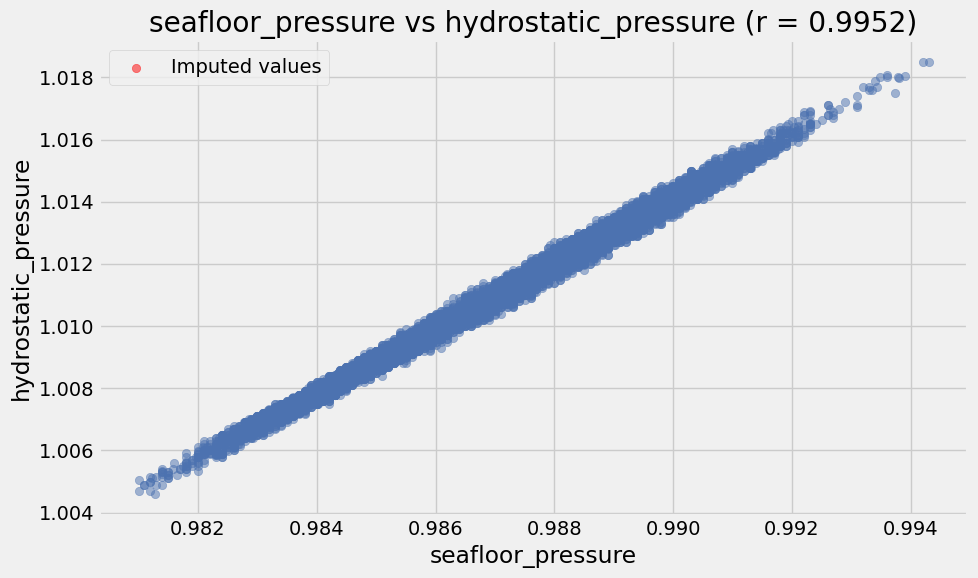


Saving completed dataset...
Saved to data/fitur_clean/seafloor2.csv


In [15]:
# ----------------------------------------
# Verify the imputation results
# ----------------------------------------

# Check the relationship between seafloor_pressure and hydrostatic_pressure
print("\nVerifying relationship between seafloor_pressure and hydrostatic_pressure...")
correlation = df_complete['seafloor_pressure'].corr(df_complete['hydrostatic_pressure'])
print(f"Correlation after imputation: {correlation:.4f}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df_complete['seafloor_pressure'], df_complete['hydrostatic_pressure'], alpha=0.5)
plt.scatter(df_complete.loc[unknown_mask, 'seafloor_pressure'], 
            df_complete.loc[unknown_mask, 'hydrostatic_pressure'], 
            color='red', alpha=0.5, label='Imputed values')
plt.xlabel('seafloor_pressure')
plt.ylabel('hydrostatic_pressure')
plt.title(f'seafloor_pressure vs hydrostatic_pressure (r = {correlation:.4f})')
plt.legend()
plt.tight_layout()
plt.savefig('seafloor_vs_hydrostatic.png')
plt.show()

# Save the complete dataframe with imputed values
print("\nSaving completed dataset...")
df_complete.to_csv('data/fitur_clean/seafloor2.csv', index=False)
print("Saved to data/fitur_clean/seafloor2.csv")

### Seafloor 3


Predicting seafloor_pressure for ALL data points...
Complete! All 21888 seafloor_pressure values replaced with model predictions.

Saving dataset with all predicted values...
Saved to data/fitur_clean/seafloor3.csv


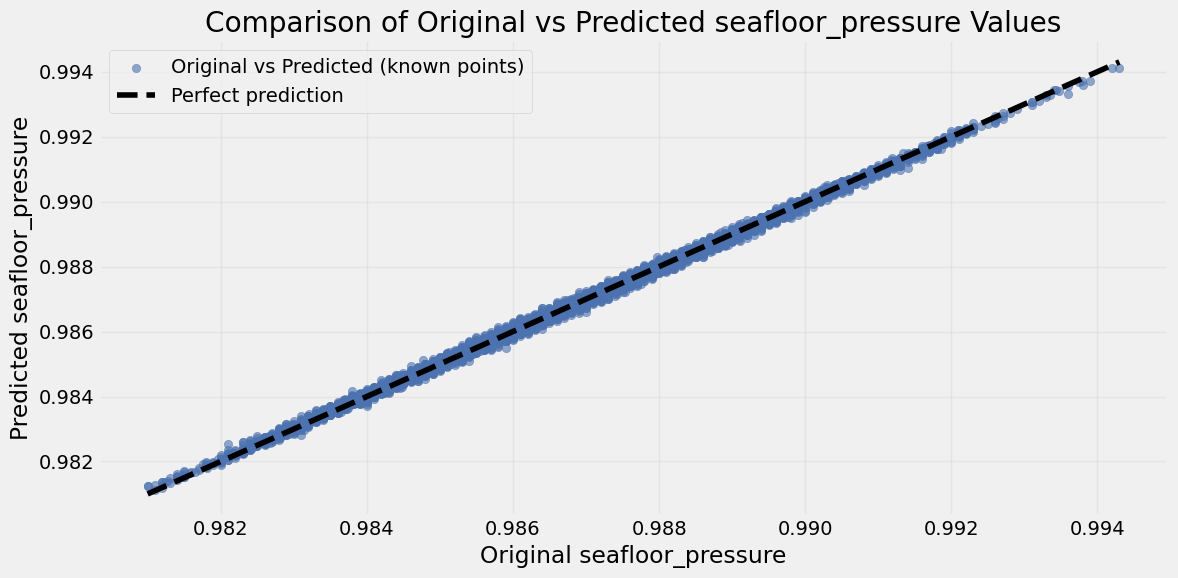


Metrics for predictions on known data points:
R² score: 0.9985
RMSE: 0.0001


In [ ]:
# ----------------------------------------
# Predict seafloor_pressure for ALL data points
# ----------------------------------------

print("\nPredicting seafloor_pressure for ALL data points...")

# First, create a copy of the dataframe to work with
X_all = df_engineered.copy()

# Handle datetime columns - extract features from depth_reading_time
if 'depth_reading_time' in X_all.columns:
    # Extract datetime components
    X_all['depth_reading_time_year'] = pd.to_datetime(X_all['depth_reading_time']).dt.year
    X_all['depth_reading_time_month'] = pd.to_datetime(X_all['depth_reading_time']).dt.month
    X_all['depth_reading_time_day'] = pd.to_datetime(X_all['depth_reading_time']).dt.day
    X_all['depth_reading_time_hour'] = pd.to_datetime(X_all['depth_reading_time']).dt.hour
    
    # Drop original datetime column
    X_all.drop(['depth_reading_time'], axis=1, inplace=True)

# Now drop target variables
X_all = X_all.drop(['seafloor_pressure', 'hydrostatic_pressure'], axis=1)

# Handle any categorical columns
cat_cols = X_all.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    X_all = pd.get_dummies(X_all, columns=cat_cols, drop_first=True)
    
    # Ensure X_all has the same columns as training data
    missing_cols = set(X_known.columns) - set(X_all.columns)
    for col in missing_cols:
        X_all[col] = 0
    
    # Keep only columns that were in the training data
    X_all = X_all[X_known.columns]

# Handle any remaining NaNs
for col in X_all.columns:
    if X_all[col].isna().sum() > 0:
        X_all[col].fillna(X_all[col].median(), inplace=True)

# Make sure all columns in X_known are in X_all with the same order
X_all = X_all[X_known.columns]

# Generate predictions for ALL data points
all_predictions = final_model.predict(X_all)

# Create a new dataframe with all predictions
df_all_predicted = df_engineered.copy()

# Replace ALL seafloor_pressure values with model predictions
df_all_predicted['seafloor_pressure'] = all_predictions

print(f"Complete! All {len(df_all_predicted)} seafloor_pressure values replaced with model predictions.")

# Save the dataset with all predicted values
print("\nSaving dataset with all predicted values...")
df_all_predicted.to_csv('data/fitur_clean/seafloor3.csv', index=False)
print("Saved to data/fitur_clean/seafloor3.csv")

# Visualize original vs predicted values (if there were any original values)
if known_mask.sum() > 0:
    plt.figure(figsize=(12, 6))
    
    # For data points where we had original values
    known_original = df_engineered.loc[known_mask, 'seafloor_pressure']
    known_predicted = df_all_predicted.loc[known_mask, 'seafloor_pressure']
    
    plt.scatter(known_original, known_predicted, alpha=0.6, label='Original vs Predicted (known points)')
    plt.plot([known_original.min(), known_original.max()], 
             [known_original.min(), known_original.max()], 
             'k--', label='Perfect prediction')
    
    plt.xlabel('Original seafloor_pressure')
    plt.ylabel('Predicted seafloor_pressure')
    plt.title('Comparison of Original vs Predicted seafloor_pressure Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('original_vs_all_predicted.png')
    plt.show()
    
    # Calculate metrics for the predictions on data points where we had original values
    r2_all = r2_score(known_original, known_predicted)
    rmse_all = np.sqrt(mean_squared_error(known_original, known_predicted))
    print(f"\nMetrics for predictions on known data points:")
    print(f"R² score: {r2_all:.4f}")
    print(f"RMSE: {rmse_all:.4f}")